In [62]:
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import csr_matrix
import h5py
from tabulate import tabulate
pdtabulate=lambda df:tabulate(df,headers='keys')
from time import time
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
train = pd.read_csv('jesterdsub2020/training.csv')
train.head()

,user_id,item_id,rating
0,13291,98,-0.670408
1,19559,8,1.436404
2,32928,50,1.711739
3,34459,29,-10.000000
4,68339,19,4.277970


In [3]:
test = pd.read_csv('jesterdsub2020/target_user_items.csv').rename(columns={'Unnamed: 0':'id'})
test.head()

,id,user_id,item_id
0,0,52841,68
1,1,51916,84
2,2,46765,65
3,3,9882,35
4,4,22323,24


In [4]:
pd.read_csv('jesterdsub2020/submision_sample.csv')

,id,rating
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
49995,49995,0
49996,49996,0
49997,49997,0
49998,49998,0


In [159]:
import functools
import operator
import itertools
from scipy.sparse.linalg import eigs
from sklearn.preprocessing import normalize
from numpy.linalg import norm

def flatten_list(a):
    return functools.reduce(operator.iconcat, a, [])



class GraphRecommender():
    
    def __init__(self):
        self.empty = None
        
    def ratings_to_csr(self, item_id, subtract_mean=False):
        df_red = self.df[self.df.item_id==item_id]
        to_subtract = 0
        if subtract_mean:
            to_subtract = df_red.user_id.apply(lambda x: self.user_mean[x])
        data = df_red.rating - to_subtract
        rows = [0]*len(df_red)
        cols = df_red.user_idx           
        return csr_matrix((data, (rows, cols)), shape=(1, self.n))

        
    def fit(self, df, fpath=False, bias=10, subtract_mean=False):
        self.df = df.copy()
        self.users = np.unique(self.df.user_id)
        self.items = np.unique(self.df.item_id)
        self.n = len(self.users)
        self.m = len(self.items)
        self.N = self.n + self.m
        self.user_id_to_idx = dict(zip(self.users, range(self.n)) )
        self.user_idx_to_id = dict(zip(  range(self.n), self.users) ) 
        self.item_id_to_idx = dict(zip(self.items, range(self.n, self.N)) )
        self.item_idx_to_id = dict(zip(  range(self.n, self.N), self.items) )         
        self.df.rating = self.df.rating + bias
        self.df['user_idx'] = self.df.user_id.apply(lambda x: self.user_id_to_idx[x] )
        self.df['item_idx'] = self.df.item_id.apply(lambda x: self.item_id_to_idx[x])
        self.bias  = bias
        
        #constructing adjacency matrix
        data = list(self.df.rating) + list(self.df.rating)
        rows = list(self.df.user_idx) + list(self.df.item_idx)
        cols = list(self.df.item_idx) + list(self.df.user_idx)
        self.shape = (self.N, self.N)
        self.A = normalize(csr_matrix((data, (rows, cols)), shape=self.shape), norm='l1', axis=0)
#         self.A_norm = normalize(self.A, norm='l1', axis=0)
        self.listN = list(range(self.N))
        
        print('Calculating user ratings mean...')
        self.user_mean = dict([(user_id, np.mean( self.df[self.df.user_id == user_id].rating) ) for user_id in self.users])

        self.item_ratings = {'normal':{}, 'relative':{}, 'mean':{}}
        print('Calculating item ratings normal....')
        self.item_ratings['normal'] = dict( [(item_id, self.ratings_to_csr(item_id, subtract_mean=False) ) for item_id in self.items] ) 
        if subtract_mean:
            print('Calculating item ratings relative...')
            self.item_ratings['relative'] = dict( [(item_id, self.ratings_to_csr(item_id, subtract_mean=True) ) for item_id in self.items] )
        print('Calculating item ratings mean')
        self.item_ratings['mean'] = dict( [ (item_id, np.mean( self.df[self.df.item_id==item_id].rating ) ) for item_id in self.items ] )
        

        if fpath!=False :
            hf = h5py.File(fpath, 'w')
            hf.close()
            for i, user_id in enumerate(self.users):
                if i%100==0:
                    print('Calculating...{:.4f}%'.format(i/self.n*100), end='\r')
                G = self.google_matrix(S=self.itemrank(user_id))
                eig_val, eig_vec = eigs(G, k=1, which='LR')
                eig_vec = (eig_vec.real).reshape(-1)[: self.n]
                with h5py.File(fpath,'a') as h5f:
                    h5f.create_dataset(str(user_id), data=eig_vec) 
        return 
    
    
    def google_matrix(self, S, alpha=0.15):
        return alpha*S/self.N + (1-alpha) * self.A
    
    def itemrank(self, user_id, top_k=10):
        df_red = self.df[self.df.user_id == user_id].sort_values('rating', ascending=False)[: top_k]
#         print(pdtabulate(df_red))
        try:
            listA, listB = zip(*itertools.combinations(df_red.item_idx, 2))
        except:
            listA, listB = ([],[])
        listA = list(listA)
        listB = list(listB)

        n = len(df_red)
        data = [1]*n*self.N*2 + [-1]*(n**2)
        rows = flatten_list([[x]*self.N +  self.listN for x in df_red.item_idx])+ list(df_red.item_idx) + listA + listB
        cols= flatten_list([  self.listN + [x]*self.N  for x in df_red.item_idx]) + list(df_red.item_idx) + listB + listA
        
        return csr_matrix((data, (rows,cols)), shape=self.shape)
    
    
    def predict(self, df2, fpath, tocsv=False, top_k=100, subtract_mean=False):
        users2 = np.unique(df2.user_id)
        users_int = np.intersect1d(self.users, users2)
        users_diff = np.setdiff1d(users2, self.users)
        ratings = np.zeros(len(df2))
        hf = h5py.File(fpath, 'r')
        count = 0
        for user_id in users_int:
            print('Calculating predictions...{:.4f}%'.format( count/len(df2)*100 ),end='\r')
            user_dset = str(user_id)
            sim_vec = np.array(hf.get(user_dset)).reshape(-1)
            indices = np.argsort(sim_vec)[::-1][: top_k]
            sim_vec = sim_vec[indices]
            vec = np.zeros(self.n)
            vec[indices] = sim_vec / norm(sim_vec, ord=1)
            df_red = df2[df2.user_id==user_id]
            if subtract_mean:
                ratings[df_red.id] = df_red.item_id.apply(lambda x: self.user_mean[user_id] + self.item_ratings['relative'][x]*vec) 
            else:
                ratings[df_red.id] = df_red.item_id.apply(lambda x: self.item_ratings['normal'][x]*vec) 
            count += len(df_red) 
        df_red = df2[df2.user_id.isin(users_diff)]
        print('\nitem ratings mean:', len(df_red), len(df_red)/len(df2)*100)
        ratings[df_red.id] = df_red.item_id.apply(lambda x: self.item_ratings['mean'][x]) 
        ratings = ratings - self.bias
        submission = pd.DataFrame({'id': df2.id, 'rating':ratings})
        if tocsv != False:
            submission.to_csv(tocsv, index=False)
        return submission
    
    
        



    

    
    



    

In [60]:
fpath = 'graph_user_10.h5'
hf = h5py.File(fpath, 'r')

# n1 = hf.get('10027')
# np.array(n1).shape

'67' in list(hf.keys())

True

In [145]:
fpath='graph_user_10.h5'    
        
gr = GraphRecommender()
t = time()
gr.fit(train, fpath=False, bias=10, subtract_mean=True)
print('\nTraining time:',time()-t)

Calculating user ratings mean...
Calculating item ratings normal....
Calculating item ratings relative...
Calculating item ratings mean

Training time: 121.70099711418152


In [146]:
t = time()
gr.predict(test, fpath, tocsv='submissions/graph_user_10_normal.csv', subtract_mean=True)
print('\nPredicting time:',time()-t)

Calculating predictions...99.9480%
item ratings mean: 25 0.05

Predicting time: 290.2554211616516


In [147]:
submission = pd.read_csv('submissions/graph_user_10_normal.csv')
submission.head()

,id,rating
0,0,3.478413
1,1,-5.452203
2,2,3.918626
3,3,0.063440
4,4,2.645115


(array([   47.,   350.,  1275.,  3464.,  8667., 14630., 12949.,  6368.,
         2020.,   230.]),
 array([-11.58482006,  -9.43239882,  -7.27997758,  -5.12755634,
         -2.9751351 ,  -0.82271386,   1.32970738,   3.48212862,
          5.63454986,   7.78697109,   9.93939233]),
 <a list of 10 Patch objects>)

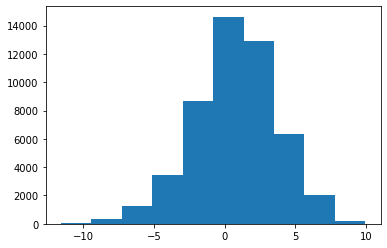

In [148]:
import matplotlib.pyplot as plt

plt.hist(submission.rating.values)